In [2]:
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl

In [3]:
import pycocotools.coco as coco
import pycocotools.mask as cocomask

In [4]:
import cv2
from matplotlib import pyplot as plt

In [5]:
import albumentations as albu

In [6]:
import os
import json

In [7]:
from torchvision import datasets
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
import torchvision

# **Создание Аннотаций и расширение датасета**

In [ ]:
transform = albu.Compose(
    [
        albu.HorizontalFlip(),
        albu.RandomBrightnessContrast(),
        albu.RandomShadow(),
        albu.Rotate(limit=45),
        albu.RandomScale()],
)

In [ ]:
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')

    last_elem = 0
    running_length = 0

    for i, elem in enumerate(binary_mask.ravel(order='F')):
        if elem == last_elem:
            pass
        else:
            counts.append(running_length)
            running_length = 0
            last_elem = elem
        running_length += 1

    counts.append(running_length)

    return rle

In [ ]:
def MakeAnnotation(mask, id, image_id, category_id=0, bbox=[]):
  annot_dict = {"id" : 0, "image_id" : 0, "category_id" : 0, "iscrowd" : 0, "segmentation" : {}, "bbox": []}
  annot_dict["id"] = id
  annot_dict["image_id"] = image_id
  annot_dict["category_id"] = category_id

  #im_bw = np.asfortranarray(mask)
  (thresh, im_bw) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  #enc = cocomask.encode(im_bw)
  enc = binary_mask_to_rle(im_bw)

  enc['counts'] = list(enc['counts'])
  annot_dict["segmentation"] = enc
  annot_dict["bbox"] = bbox

  return annot_dict

In [ ]:
def MakeImageSection(file_name, image_id):
  idict = {"file_name" : "", "height" : 512, "width" : 512, "id" : 0}
  idict["id"] = image_id
  idict["file_name"] = file_name

  return idict

In [ ]:
dir_path = "./Dataset/Main/"
dir_path_masks = "./Dataset/Masks/"
output_path = "./Dataset/Output/data/"

images_dlist = []
annots_dlist = []

for k, path in enumerate(os.listdir(dir_path)):
  image = cv2.imread(dir_path + path)
  #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  masks = []
  classes = []

  for dir in os.listdir(dir_path_masks):
    mask = cv2.imread(dir_path_masks + dir + "/" + path, cv2.IMREAD_GRAYSCALE)
    avg_color_per_row = np.average(mask, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    if (avg_color >= 0.5):
      masks.append(mask)
      cl = ""
      if ("Chair" in dir):
        cl = "chair"
      else:
        cl = "table"
      classes.append(cl)

  if (len(classes) == 0):
    continue

  file_name = str(k) + ".jpg"

  cv2.imwrite(output_path + file_name, image)

  image_id = k*10000

  images_dlist.append(MakeImageSection(file_name, image_id))

  for i, x in enumerate(masks):
    a = list(cv2.boundingRect(x))
    annots_dlist.append(MakeAnnotation(x, image_id + i, image_id, 1 if classes[i] == "chair" else 2, a))

  for i in range(15):
    i += 1
    transformed = transform(image=image, masks=masks)
    img = transformed["image"]
    file_n = str(k) + "_" + str(i) + ".jpg"
    id = image_id + i*100
    cv2.imwrite(output_path + file_n, img)

    images_dlist.append(MakeImageSection(file_n, id))

    for j, x in enumerate(masks):
      a = list(cv2.boundingRect(x))
      annots_dlist.append(MakeAnnotation(x, id + j, id, 1 if classes[j] == "chair" else 2, a))

In [ ]:
cocojson = {"images" : images_dlist, "annotations" : annots_dlist, "categories": [{"supercategory": "furniture", "id" : 1, "name": "chair"}, {"supercategory": "furniture", "id" : 2, "name": "table"}]}

with open("./Dataset/Output/annot.json", "w") as outfile:
    json.dump(cocojson, outfile)

# Модель

In [8]:
class CocoWrapper(Dataset):
    def __init__(self):
        dataset_path = "./Dataset/Output/"
        self.dataset = datasets.CocoDetection(root=dataset_path + "data/", annFile=dataset_path+"annot.json")

        self.dataset = datasets.wrap_dataset_for_transforms_v2(self.dataset)

    def __len__(self):
        return self.dataset.__len__()

    def __getitem__(self, idx):
        img = self.dataset[idx][0]
        data = self.dataset[idx][1]
        boxes = data["boxes"]
        masks = data["masks"]
        labels = data["labels"]
        tr = transforms.ToTensor()
        d = {"boxes" : boxes, "masks": masks, "labels": labels}
        img = tr(img)

        return img, d

In [9]:
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)

class CustomLoader(object):

    def __init__(self, dataset, my_bsz, drop_last=False):
        self.ds = dataset
        self.my_bsz = my_bsz
        self.drop_last = drop_last
        self.num = 0
        self.dslen = len(self.ds)

    def __iter__(self):
        return self

    def __next__(self):
        if self.num*self.my_bsz > self.dslen:
            self.num = 0
            raise StopIteration
        f = clamp(self.num*self.my_bsz, 0, self.dslen)
        l = clamp(self.num*self.my_bsz + self.my_bsz, 0, self.dslen)
        img_batch = []
        data_batch = []
        for i in range(f, l):
          x = self.ds[i]
          img_batch.append(x[0])
          data_batch.append(x[1])
        self.num += 1
        return img_batch, data_batch

In [10]:
class FurSeg(pl.LightningModule):
    def __init__(self, batch_size, thres=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.loss_list = []
        self.avg_loss_stats = []
        self.thres = thres
        self.TP = 0
        self.FP = 0
        self.FN = 0
        self.weights = MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1
        self.MaskRCNN = maskrcnn_resnet50_fpn_v2(weights=self.weights)

        for param in self.MaskRCNN.parameters():
          param.requires_grad = False

        self.MaskRCNN.roi_heads.box_predictor.cls_score = torch.nn.Linear(in_features=1024, out_features=3, bias=True)

        ds = CocoWrapper()

        self.train_set, self.val_set = torch.utils.data.random_split(ds, [0.8, 0.2])

    def forward(self, x):
        return self.MaskRCNN(x)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        self.MaskRCNN.train()
        loss_dict = self.MaskRCNN(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        #print(losses, "train loss on batch #", batch_idx)
        self.loss_list.append(losses)
        return {"loss": losses}

    def test_step(self, batch, batch_idx):
        images, targets = batch
        self.MaskRCNN.eval()
        res = self.MaskRCNN(images)

        for i, im in enumerate(images):
          true_boxes = targets[i]["boxes"]
          pred_boxes = res[i]["boxes"]
          true_labels = targets[i]["labels"]
          pred_labels = res[i]["labels"]

          iou = torchvision.ops.box_iou(true_boxes, pred_boxes)

          for true_index, boxs in enumerate(iou):
            for pred_index, value in enumerate(boxs):
              if value > self.thres:
                if true_labels[true_index] == pred_labels[pred_index]:
                  self.TP += 1
              elif value == 0:
                self.FN += 1
              else:
                if true_labels[true_index] == pred_labels[pred_index]:
                  self.FP += 1

    def compute_metrics(self):
        if (self.TP + self.FP) == 0 or (self.TP + self.FN) == 0:
          return 0, 0
        prec = self.TP/(self.TP + self.FP)
        rec = self.TP/(self.TP + self.FN)
        return prec, rec

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.loss_list).mean()
        print("EPOCH END", avg_loss, "- average loss")
        self.loss_list.clear()
        self.avg_loss_stats.append(avg_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def train_dataloader(self):
        train_loader = CustomLoader(self.train_set, self.batch_size)
        return train_loader

    def test_dataloader(self):
        test_loader = CustomLoader(self.val_set, self.batch_size)
        return test_loader


In [ ]:
model = FurSeg(batch_size=12)

In [ ]:
trainer = pl.Trainer(max_epochs=15, accelerator="gpu")

# **Тренировка**

In [ ]:
trainer.fit(model)

# **Тестирование**

In [ ]:
trainer.test(model)

In [ ]:
print(model.compute_metrics())

In [13]:
img = cv2.imread("./Refs/chair2.jpg")
tr = transforms.ToTensor()
img = tr(img)
model.MaskRCNN.eval()
res = model([img])

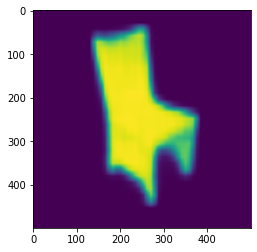

In [19]:
plt.imshow(to_pil_image(res[0]["masks"][0]))